In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
sns.set()
%matplotlib notebook

### 5.6.1 简单线性回归

<IPython.core.display.Javascript object>


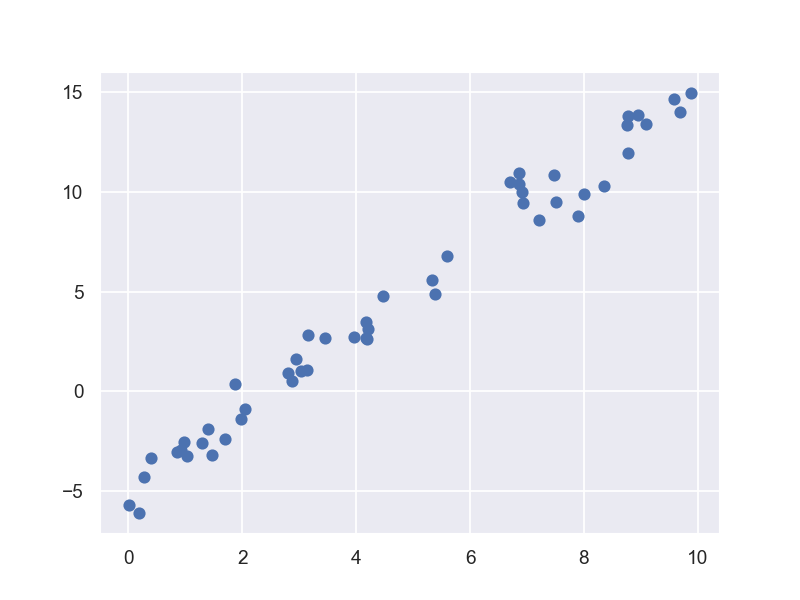

In [19]:
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = 2 * x - 5 + rng.randn(50)
plt.figure()
plt.scatter(x, y);

<IPython.core.display.Javascript object>


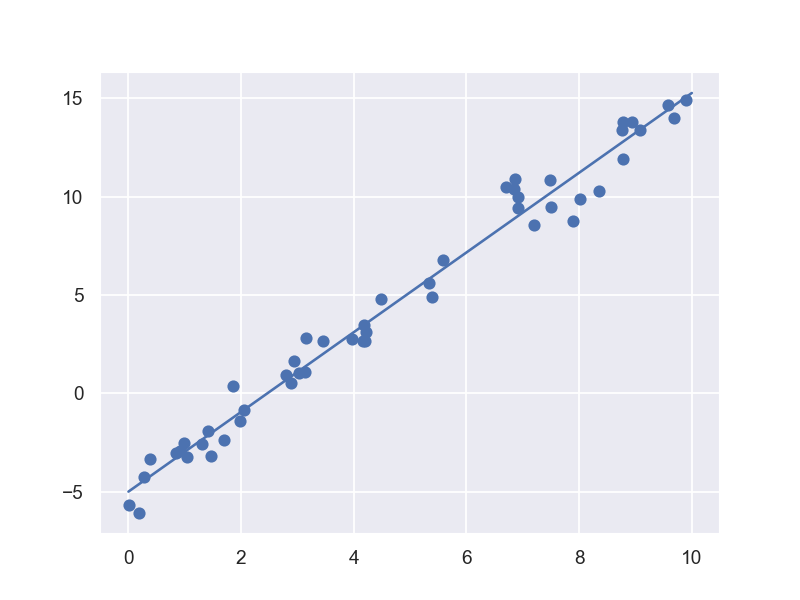

In [20]:
from sklearn.linear_model import LinearRegression

model = LinearRegression(fit_intercept=True)
model.fit(x[ : , np.newaxis], y)

xfit = np.linspace(0, 10, 1000)
yfit = model.predict(xfit[ : , np.newaxis])

plt.figure()
plt.scatter(x, y)
plt.plot(xfit, yfit)

数据的斜率和截距都在模型的拟合参数中

In [21]:
print("Model slope:     ", model.coef_[0])
print("Model intercept: ", model.intercept_)

Model slope:      2.027208810360695
Model intercept:  -4.998577085553202


处理多维度的线性回归模型

In [22]:
rng = np.random.RandomState(1)
X = 10 * rng.rand(100, 3)
y = 0.5 + np.dot(X, [1.5, -2, 1.])

model.fit(X, y)
print(model.intercept_)
print(model.coef_)

0.5000000000000144
[ 1.5 -2.   1. ]


### 5.6.2 基函数回归

#### 1.多项式基函数

In [23]:
from sklearn.preprocessing import PolynomialFeatures

In [24]:
x = np.array([2, 3, 4])
poly = PolynomialFeatures(3, include_bias=False)
poly.fit_transform(x[ : , None])

array([[ 2.,  4.,  8.],
       [ 3.,  9., 27.],
       [ 4., 16., 64.]])

In [25]:
# 创建一个 7 次多项式回归模型

from sklearn.pipeline import make_pipeline

poly_model = make_pipeline(PolynomialFeatures(7), LinearRegression())

<IPython.core.display.Javascript object>


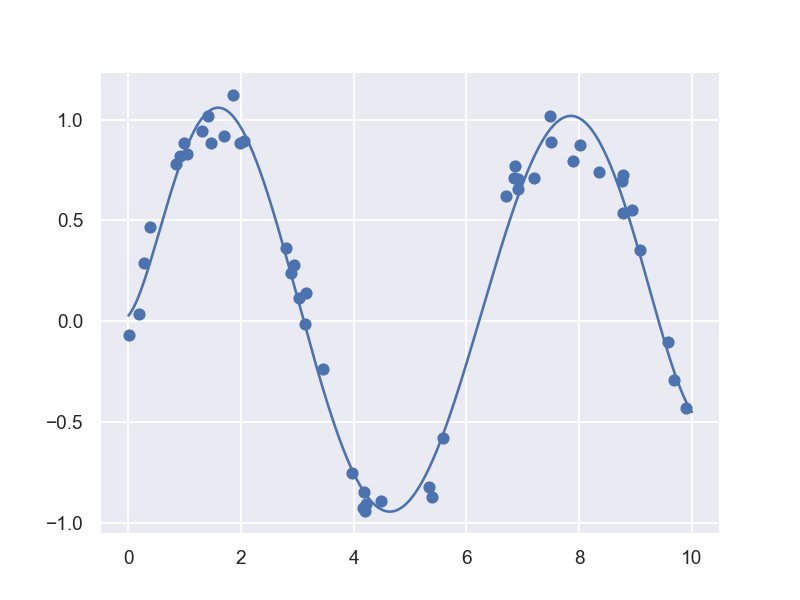

In [27]:
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = np.sin(x) + 0.1 * rng.randn(50)

poly_model.fit(x[ : , np.newaxis], y)
yfit = poly_model.predict(xfit[ : , np.newaxis])

plt.figure()
plt.scatter(x, y)
plt.plot(xfit, yfit)

#### 2.高斯基函数

<IPython.core.display.Javascript object>


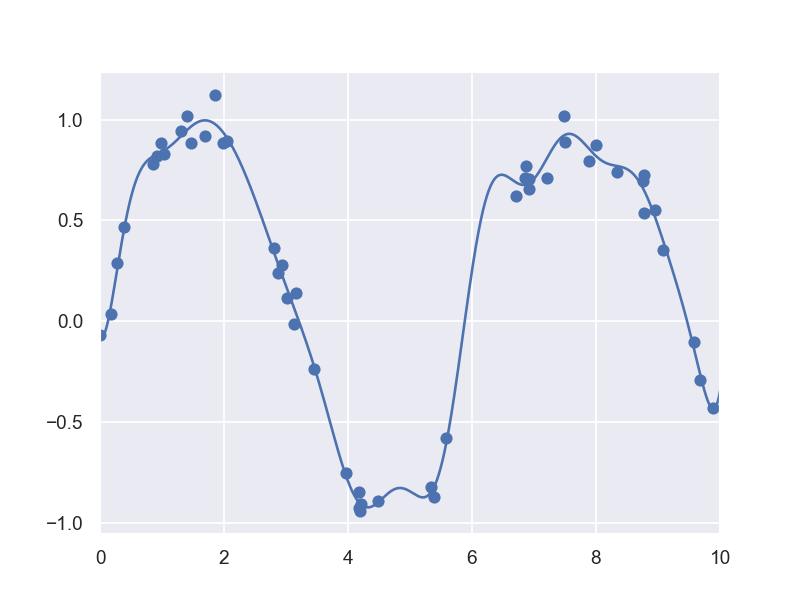

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression


class GaussianFeatures(BaseEstimator, TransformerMixin):
    """一维输入均匀分布的高斯特征"""
    
    def __init__(self, N, width_factor=2.0):
        self.N = N
        self.width_factor = width_factor
    
    @staticmethod
    def _gauss_basis(x, y, width, axis=None):
        arg = (x - y) / width
        return np.exp(-0.5 * np.sum(arg ** 2, axis))
    
    def fit(self, X, y=None):
        # 在数据区间中创建 N 个高斯分布中心
        self.centers_ = np.linspace(X.min(), X.max(), self.N)
        self.width_ = self.width_factor * (self.centers_[1] - self.centers_[0])
        return self
    
    def transform(self, X):
        return self._gauss_basis(X[ : , : , np.newaxis], self.centers_,
                                 self.width_, axis=1)
        
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = np.sin(x) + 0.1 * rng.randn(50)
xfit = np.linspace(0, 10, 1000)
gauss_model = make_pipeline(GaussianFeatures(20),
                            LinearRegression())
gauss_model.fit(x[ : , np.newaxis], y)
yfit = gauss_model.predict(xfit[ : , np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit)
plt.xlim(0, 10);

### 5.6.3 正则化

<IPython.core.display.Javascript object>


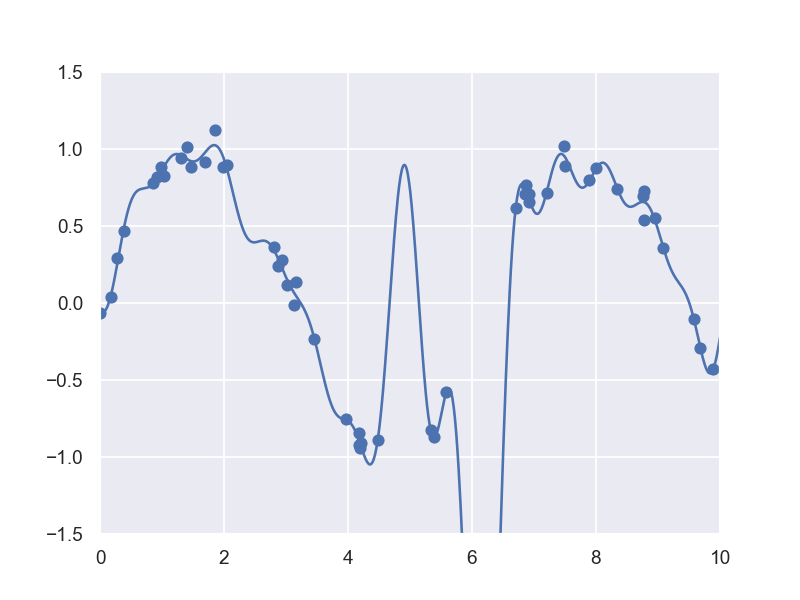

In [9]:
model = make_pipeline(GaussianFeatures(30), 
                      LinearRegression())
model.fit(x[ : , np.newaxis], y)

plt.figure()
plt.scatter(x, y)
plt.plot(xfit, model.predict(xfit[ : , np.newaxis]))

plt.xlim(0, 10)
plt.ylim(-1.5, 1.5);

<IPython.core.display.Javascript object>


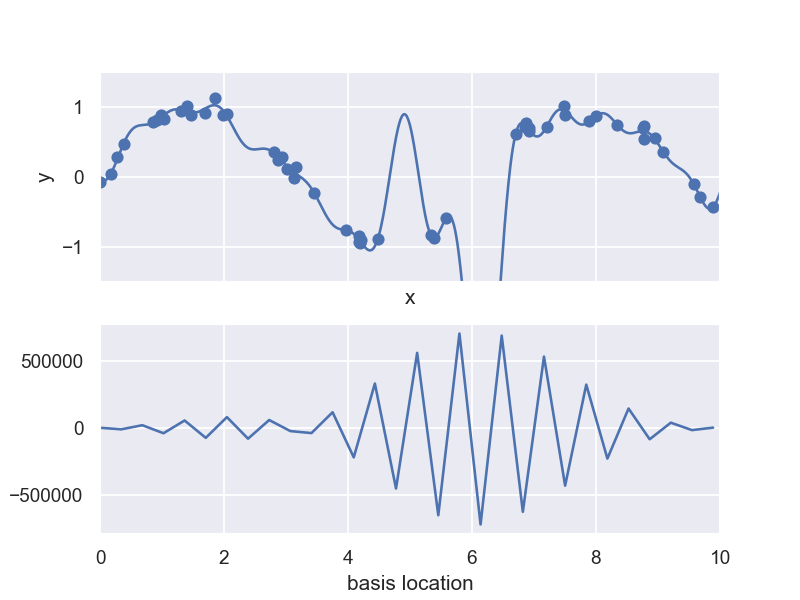

In [14]:
def basis_plot(model, title=None):
    fig, ax = plt.subplots(2, sharex=True)
    model.fit(x[ : , np.newaxis], y)
    ax[0].scatter(x, y)
    ax[0].plot(xfit, model.predict(xfit[ : , np.newaxis]))
    ax[0].set(xlabel='x', ylabel='y', ylim=(-1.5, 1.5))
    
    if title:
        ax[0].set_title(title)
    
    ax[1].plot(model.steps[0][1].centers_,
               model.steps[1][1].coef_)
    ax[1].set(xlabel='basis location',
              ylabel='coefficient',
              xlim=(0, 10))
    
model = make_pipeline(GaussianFeatures(30), LinearRegression())
basis_plot(model)

<IPython.core.display.Javascript object>


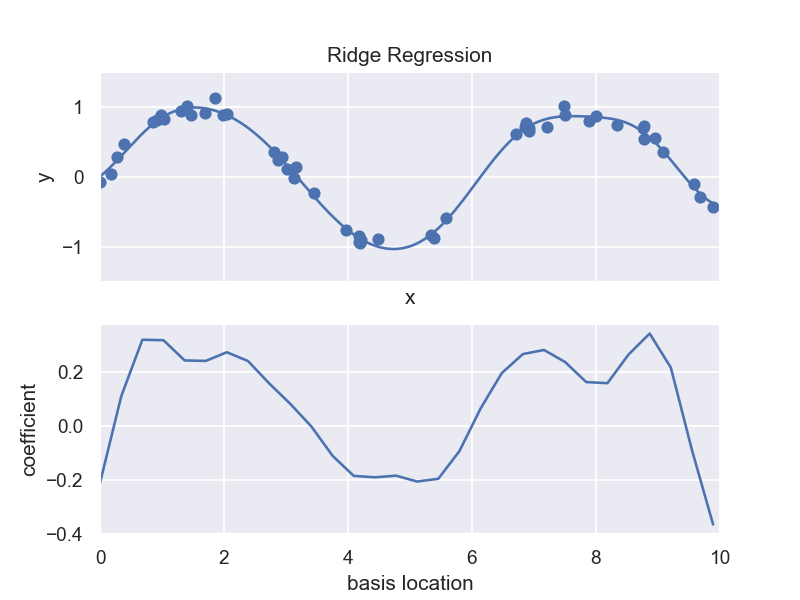

In [15]:
from sklearn.linear_model import Ridge

model = make_pipeline(GaussianFeatures(30), Ridge(alpha=0.1))
basis_plot(model, title='Ridge Regression')

### 5.6.4 案例：预测自行车流量

加载两个数据集，用日期作索引

In [23]:
import pandas as pd

counts = pd.read_csv("../data/fremont_hourly.csv", index_col="Date", parse_dates=True)
weather = pd.read_csv('../data/BicycleWeather.csv', index_col='DATE', parse_dates=True)

计算每一天的自行车流量，将结果放到一个新的 DataFrame 中

In [25]:
# daily = counts.resample('d', how='sum')
daily = counts.resample('d').sum()
daily['Total'] = daily.sum(axis=1)
daily = daily[['Total']]  # remove other columns

In [26]:
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for i in range(7):
    daily[days[i]] = (daily.index.dayofweek == i).astype(float)